# Visualizations Notebook
_by Joel Silverman_


-----

This notebook provides visualizations of a binary food photography classification using first principles of photography to separate relatively "good" photos from "bad" photos.  For a project summary, please see the README.md file in the project folder.  

Topics covered include:
- Library Imports
- Data Import
- Data Lists
- Show Randomly Selected "Good" and "Bad" Photos As Examples of Each Class
- Import the Whole Training Set for Both Classes

Inspiration and some of the code for this notebook was borrowed from Eunjoo Byeon's Excellent article on x-ray images found here:  https://towardsdatascience.com/exploratory-data-analysis-ideas-for-image-classification-d3fc6bbfb2d2

In [1]:
# Library Imports Used in this Notebook:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from math import ceil
from tensorflow.keras.preprocessing import image
#%matplotlib inline

In [2]:
# Make the path to training photos a variable  
train_dir = 'classy-food/data/yelp_set2/train' 

# Make the lists of .jpg image file names from the image class subfolders within the training folder
good_imgs = [fn for fn in os.listdir(f'{train_dir}/good') if fn.endswith('.jpg')]
bad_imgs = [fn for fn in os.listdir(f'{train_dir}/bad') if fn.endswith('.jpg')]

'good1387.jpg'

### Randomly Selected "Good" and "Bad" Photos As Examples of Each Class
**The cell below can be run repeately to see more examples**

The examples below were manually labeled using basic photographic criteria such as proper focus, exposure, temperature/tint, and composition.  These are more fully described in the README.md file.

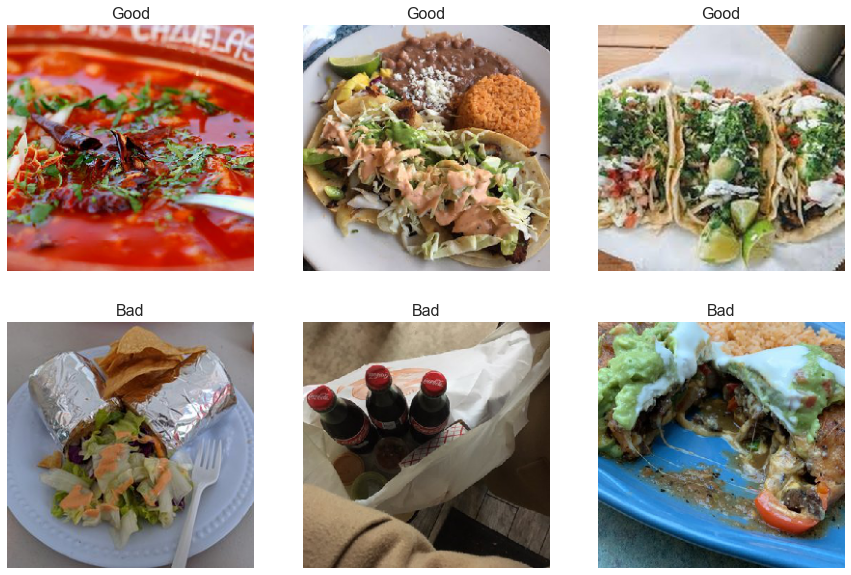

(380, 380)

In [470]:
select_good = np.random.choice(good_imgs, 3, replace = False)
select_bad = np.random.choice(bad_imgs, 3, replace = False)

# Plotting a 2 x 3 image matrix; 
fig = plt.figure(figsize = (15,10))
for i in range(6):
    if i < 3:
        fp = f'{train_dir}/good/{select_good[i]}'
        label = 'Good'
    else:
        fp = f'{train_dir}/bad/{select_bad[i-3]}'
        label = 'Bad'
    ax = fig.add_subplot(2, 3, i+1, aspect='equal')
    
    # to plot without rescaling, remove target_size
    fn = image.load_img(fp, target_size = (256,256), 
                        color_mode='rgb')
    plt.imshow(fn, )
    plt.title(label,fontsize=16)
    plt.axis('off')
plt.savefig('classy-food/visuals/good_bad_pic_grid',dpi=400,format='jpg')
plt.show()
# also check the number of files here
len(good_imgs), len(bad_imgs)

### Process Each Image for Analysis
Transform Each Image Into A 1-Dimensional Grayscale Array, Then Concatenate Each With The Rest of Its Class

In [3]:
# making n X m matrix
def img2np(path, list_of_filename, size = (128,128)):
    # iterating through each file
    for fn in list_of_filename:
        fp = path + fn
        current_image = image.load_img(fp, target_size = size, 
                                       color_mode = 'grayscale')
        # covert image to a matrix
        img_ts = image.img_to_array(current_image)
        # turn that into a vector / 1D array
        img_ts = [img_ts.ravel()]
        try:
            # concatenate different images
            full_mat = np.concatenate((full_mat, img_ts))
        except UnboundLocalError: 
            # if not assigned yet, assign one
            full_mat = img_ts
    return full_mat

# run it on our folders
good_images = img2np(f'{train_dir}/good/', good_imgs)
bad_images = img2np(f'{train_dir}/bad/', bad_imgs)

In [4]:
# Check the shape of one of the output arrays.
good_images.shape

(380, 16384)

### An Average Grayscale Image For Each Class
The grayscale arrays from the previous step were combined into an average image for each class of photo.  The composites below show the average "good" photo is lighter than the average "bad" photo, probably due to lack of bright, diffused lighting in the restaurant when the photo was taken.  Better photos usually have moderate amounts of diffused neutral light, although modern cameras in smartphones usually compensate for this through software adjustments to some degree.

The grayscale images below are show in a perceptually uniform sequential colormap called "plasma" from Matplotlib where dark blue represents black and bright yellow represents white.  This colormap made differences a little easier to see than grayscale.

<img src="../visuals/plasma.png" alt="color map figure" width= "550"/>

In [5]:
def find_mean_img(full_mat, title, size = (128,128)):
    # calculate the average
    mean_img = np.mean(full_mat, axis = 0)
    # reshape it back to a matrix
    mean_img = mean_img.reshape(size)
    plt.imshow(mean_img, vmin=0, vmax=255, cmap='plasma')
    plt.title(f'Average {title}')
    plt.axis('off')
    plt.savefig(('classy-food/visuals/Average_'+ title + '.jpg'),dpi=200,format='jpg')
    plt.show()
    return mean_img

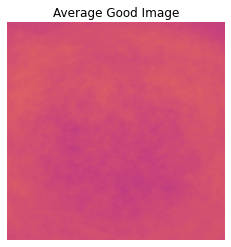

In [6]:
good_mean = find_mean_img(good_images, 'Good Image')

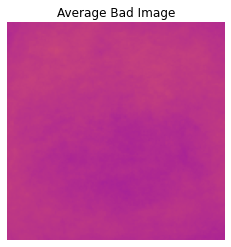

In [7]:
bad_mean = find_mean_img(bad_images, 'Bad Image')

### An Average Color Image for Each Class, Plus Histograms
In addition to the grayscale composite image pair above, a color composite image for each class was made below.  The main discernable trait is that the "bad" image is darker, especially near the edges.  The histograms look similar in each of the three color bands (red, green, and blue), however, the "good" composite image is spread out further across the sprectrum from dark (left) to light (right) whereas the "bad" composite image is more condensed into the darker portion (left).  The histogram approach utilized here owes much to this organization's thorough tutorial on image processing: https://datacarpentry.org/image-processing/aio/index.html#color-histograms

In [111]:
def composite_array(path, list_of_filenames):
    # iterating through each file
    divisor=len(list_of_filenames)
    full_mat=[0,0,0]
    for fn in list_of_filenames:
        fp = path + fn
        current_image = image.load_img(fp, 
                                       target_size = (256,256), 
                                       color_mode = 'rgb')
        # covert image to a array for for finding mean value
        img_ts = image.img_to_array(current_image)
        full_mat = img_ts + full_mat
    return (full_mat/divisor)

# run it on the folders
good_comp_arr = composite_array(f'{train_dir}/good/', good_imgs)
bad_comp_arr = composite_array(f'{train_dir}/bad/', bad_imgs)

In [113]:
good_comp_arr.shape

(256, 256, 3)

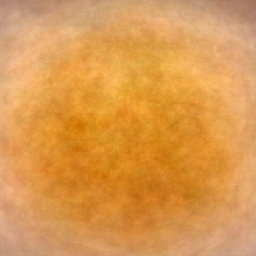

In [114]:
good_comp_img = image.array_to_img(good_comp_arr)
good_comp_img

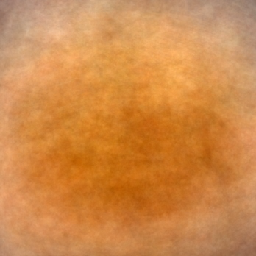

In [115]:
bad_comp_img = image.array_to_img(bad_comp_arr)
bad_comp_img

In [463]:
# tuple to select colors of each channel line
def color_hist(image,title='Color Historgram'):
    colors = ("red", "green", "blue")
    channel_ids = (0, 1, 2)
    y2 = 0
    # create the histogram plot, with three lines, one for
    # each color
    plt.figure(figsize=(10,8))
    plt.xlim([60, 175])
    for channel_id, c in zip(channel_ids, colors):
        histogram, bin_edges = np.histogram(
            image[:, :, channel_id], bins=256, range=(0, 256)
        )
        plt.plot(bin_edges[0:-1], histogram, color=c)
        plt.fill_between(np.linspace(0, 256, 256), y2, histogram, color=c, alpha=0.3)
    plt.title(title)
    plt.xlabel("Color Value in RGB")
    plt.ylabel("Pixel Count")
    return plt.show()   

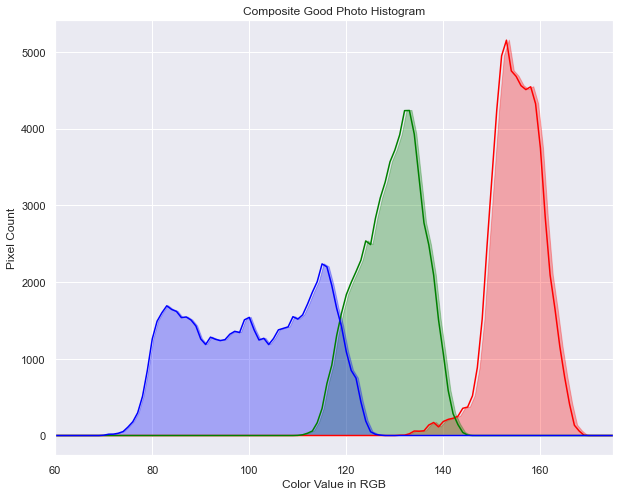

In [464]:
color_hist(good_comp_arr, 'Composite Good Photo Histogram')

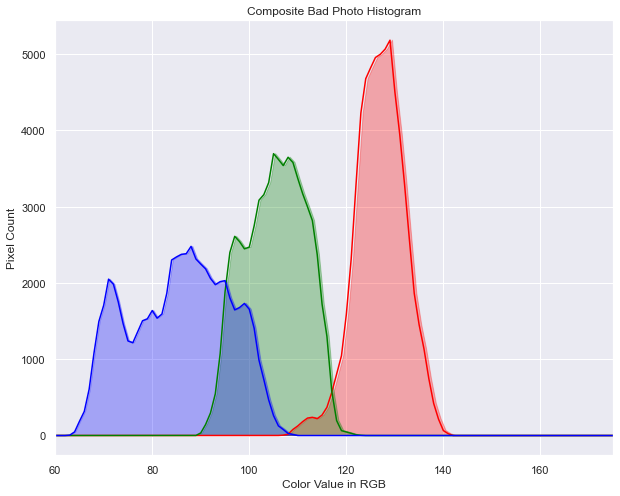

In [465]:
color_hist(bad_comp_arr, 'Composite Bad Photo Histogram')

### Contrast Image
The contrast image is the difference between the mean image for each class.  The right bottom and top corners show more difference.  This probably relates to vignetting, a common photgraphic artifact in under-exposed photos where the corners appear darker than the center.  Thus differences in the amount of light shows up in the contrast image too.

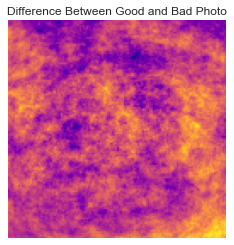

In [517]:
contrast_mean = good_mean - bad_mean
plt.imshow(contrast_mean, cmap='plasma')
plt.title(f'Difference Between Good and Bad Photo')
plt.axis('off')
plt.savefig(('classy-food/visuals/contrast_btwn_avg_good_and_avg_bad_photo' + '.jpg'),dpi=200,format='jpg')
plt.show()

### Dimensionality Reduction
In this section Priciple Components Analysis (PCA) is used to show the components that do the best job of describing each class of food.  The eigenvectors of the PCA of the image matrix is reshaped and plotted.  This technique was originally called eigenfaces because it was used for facial recognition research.  The eigenfaces below describe 70% of the variability for each class.  Note that a round shape can often be seen in the first components of each class.  This corresponds to the plate found in many food photos.  It is possible that uncentered plates are more likely to be "bad" photos.  Also note the difference in texture between the two classes; "good" seems to have finer texture.  Also note it takes more eigenfaces to describe "good" than "bad" photos, perhaps owing to higher variability in the former.

In [8]:
def eigenimages(full_mat, title, n_comp = 0.7, size = (128, 128)):
    # fit PCA to describe n_comp * variability in the class
    pca = PCA(n_components = n_comp, whiten = True)
    pca.fit(full_mat)
    print('Number of PC: ', pca.n_components_)
    return pca
  
def plot_pca(pca, size = (128,128)):
    # plot eigenimages in a grid
    n = pca.n_components_
    fig = plt.figure(figsize=(15,15))
    r = int(n**.5)
    c = ceil(n/ r)
    for i in range(n):
        ax = fig.add_subplot(r, c, i + 1, xticks = [], yticks = [])
        ax.imshow(pca.components_[i].reshape(size), cmap='plasma')
    plt.axis('off')
    plt.show()

Number of PC:  67


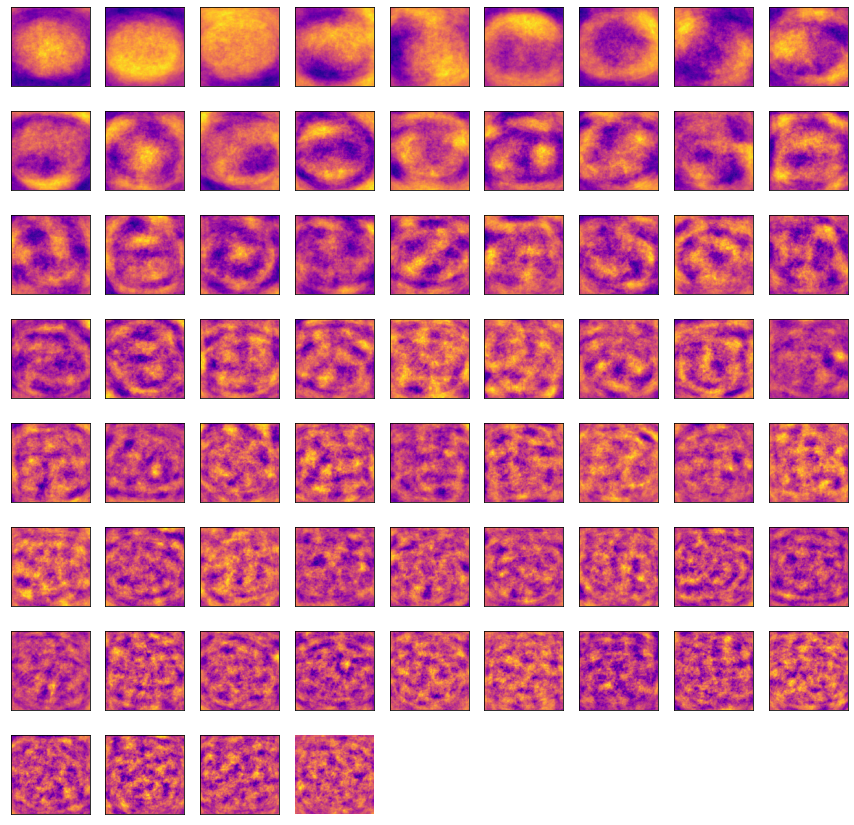

In [9]:
plot_pca(eigenimages(good_images, 'GOOD'))

Number of PC:  44


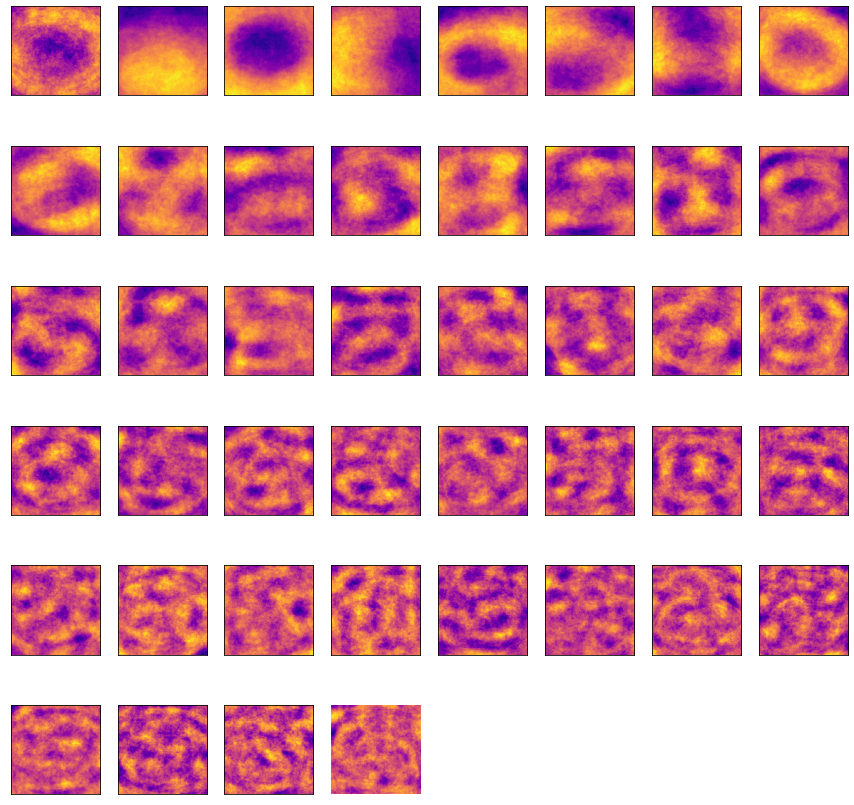

In [10]:
plot_pca(eigenimages(bad_images, 'BAD'))

### High Eigen Value Photos
Transforming the original images into PCA space allows one to find the photos with the largest eigen values and these should help visualize much difference between the classes.  It appears the best "good" food photos are usually centered on a monotone plate while the worst "bad" food photos are of partially / mostly eaten, and are not centered on a plate.

In [49]:
loading_labels = [f'loading {n}' for n in range(1, 67)]

In [50]:
good_pic_pca = eigenimages(good_images,'GOOD')
bad_pic_pca = eigenimages(bad_images,'BAD')

Number of PC:  67
Number of PC:  44


In [106]:
good_pca_values = good_pic_pca.transform(good_images)
pd.DataFrame(good_pca_values).sort_values(by=0)

0         1         2         3         4         5         6   \
352 -2.739640  0.732600  0.269974  0.425661 -0.643853  0.650784  0.848095   
361 -2.657955  0.002869  0.587560  1.154821  1.401419  0.164376 -0.083297   
131 -2.529412 -0.165928  0.776170 -0.243313 -0.557625  0.491705  0.618128   
171 -2.526086  0.344680 -0.464877  0.552307 -0.017821 -0.715946  1.293318   
166 -2.243050 -0.688765  0.421596  0.293923  0.332570 -0.505198  0.669939   
..        ...       ...       ...       ...       ...       ...       ...   
61   2.250281  0.020432 -0.799672  1.456420 -0.359498  1.111423 -0.132387   
187  2.268050  0.093490  0.325065  1.218297  0.461235  0.269868  1.158965   
335  2.817891 -0.312091 -2.779827 -1.091183  1.843906  0.584488 -0.408847   
40   3.014956 -0.524624  0.078288  2.965569  0.359618 -0.490043  2.731508   
315  3.101929 -0.155203 -0.290133  2.580682  0.443921 -0.808443  1.802589   

           7         8         9   ...        57        58        59  \
352  0.705604 -0.220813 -1.055680  ... -1.128779  0.284576 -0.481544   
361  0.714836 -0.304085  0.220341  ... -0.532773 -1.864998 -0.608505   
131  0.001020 -0.375892 -2.244068  ... -1.410034  0.026665 -0.443572   
171 -0.130178 -0.338453  0.867918  ... -0.257872  0.856905  0.117027   
166  0.280790 -0.053603  0.588655  ... -0.482254 -0.408874 -0.975187   
..        ...       ...       ...  ...       ...       ...       ...   
61   1.525596 -0.226627  0.082767  ...  1.366119 -0.251229  0.583072   
187 -0.207387  0.775941  0.034718  ...  0.258621  0.410002 -0.994262   
335 -1.817152  0.363895 -0.992119  ... -0.827732 -0.392445 -0.684260   
40  -0.188681 -1.253361  1.164212  ...  0.239043 -1.022418 -1.160983   
315  0.697895 -0.100950  0.520270  ...  1.139967 -0.542918 -0.236290   

           60        61        62        63        64        65        66  
352 -0.975816  0.425098 -0.086271  1.628861 -0.204020  0.008752 -0.232965  
361  1.262605  0.363972  0.569511 -0.201153  0.047515 -0.561375  0.482551  
131 -0.602073  0.417803 -0.808953 -0.566330 -1.533621 -0.659352 -0.324616  
171  0.790218  0.278991  1.206605 -0.328730  0.475182  0.094429 -0.347586  
166 -0.703856 -0.228565 -0.527126  0.909002 -0.085829  1.361358  0.029818  
..        ...       ...       ...       ...       ...       ...       ...  
61   0.157508 -0.353739 -0.825537 -0.484871  0.520293 -0.933811 -0.371150  
187  1.032831  0.727414 -1.227419  2.311896  1.126814 -0.436066 -1.468438  
335 -0.976366 -2.095731 -0.014156 -0.763179 -0.415691  0.125226  0.147461  
40  -0.610969 -0.845726  0.680759  0.114334 -0.781186  0.229039  0.176141  
315 -0.361289  0.187517 -0.234099  0.154202  0.639025 -0.420277 -0.752935  

[380 rows x 67 columns]

In [107]:
bad_pca_values = bad_pic_pca.transform(bad_images)
pd.DataFrame(bad_pca_values).sort_values(by=0)

0         1         2         3         4         5         6   \
206 -2.963063  1.375359  0.479448  1.151471 -0.398889 -1.429787 -0.152480   
315 -2.861446  0.254285 -0.153756 -0.440758 -0.657215  0.124452  0.722274   
88  -2.814684  0.327045  1.508571  0.392415  1.167295 -0.965859 -1.990577   
173 -2.577237  0.313841  0.969886 -0.000716  0.172391  1.779500  0.884922   
330 -2.510319 -0.447986  0.015630  0.227541  0.449918  0.794074 -1.378542   
..        ...       ...       ...       ...       ...       ...       ...   
179  2.132226  0.243964 -1.218148  0.908261  0.185935  0.509450  0.823480   
203  2.370288  1.477488  0.062860  0.339497 -0.998361  0.761195 -0.410042   
71   2.769281  0.201462 -0.460695 -1.993270  1.479317 -0.512451 -0.063625   
90   2.930661  0.430353 -1.833678  0.839867  0.073983 -0.632442  0.399822   
130  2.985400  1.835935  0.344108 -0.236013 -0.205358  0.904231  0.245533   

           7         8         9   ...        34        35        36  \
206 -0.753368 -0.644290 -0.987070  ... -0.538820 -1.083317 -0.835144   
315 -0.679529 -0.159544  0.326795  ...  1.355651  0.103489 -0.783814   
88  -0.336035 -1.179140 -0.051843  ... -0.230634  0.411239  0.441154   
173  1.578175  0.630107  0.144522  ...  0.319625  0.580824 -0.629562   
330  0.289079  1.109884 -0.277070  ... -0.041315  1.088163 -0.152845   
..        ...       ...       ...  ...       ...       ...       ...   
179 -1.393527 -0.402103  0.540284  ... -0.246679 -0.368292  0.191071   
203 -1.450415  0.585291  0.407553  ... -0.913573  1.341599 -0.272725   
71  -0.682342 -0.861732 -1.174880  ...  0.574970 -1.222520  0.790326   
90   1.045731 -1.929449 -0.139879  ... -0.419745  0.546859 -0.109674   
130 -0.427207 -0.398249  0.532367  ...  0.552151 -0.248893 -0.134345   

           37        38        39        40        41        42        43  
206  0.154810 -0.472033  0.140122  0.854838  0.317713 -0.419172  0.183215  
315  0.319841  0.543836  1.928096  0.690420  1.960270 -0.164298 -1.553550  
88   0.101780 -0.123989 -0.537691  1.751710 -0.549118 -0.216520  1.098221  
173  0.041371  0.211597  0.626962  0.312323  0.555631  0.015314  0.986618  
330 -0.463393 -0.029265  0.999509 -0.742272  0.262809 -0.230266 -0.088035  
..        ...       ...       ...       ...       ...       ...       ...  
179 -0.311396  0.188614  0.634484 -0.592394  0.873624 -0.686132 -0.012782  
203  0.544388  0.443474  0.026014 -0.759659  0.761718 -0.427181 -0.406912  
71  -0.682785 -0.819051 -0.207167 -0.872479 -2.265159  0.371296  1.201853  
90   0.880858  0.422548  0.430880  0.349017 -0.202066 -0.887771  1.411420  
130 -0.585922  0.146179  0.422221 -0.893896 -0.702350  0.616572 -0.180543  

[380 rows x 44 columns]

In [108]:
select_good = good_imgs[315],good_imgs[335],good_imgs[187]
select_bad = bad_imgs[130],bad_imgs[90],bad_imgs[71]

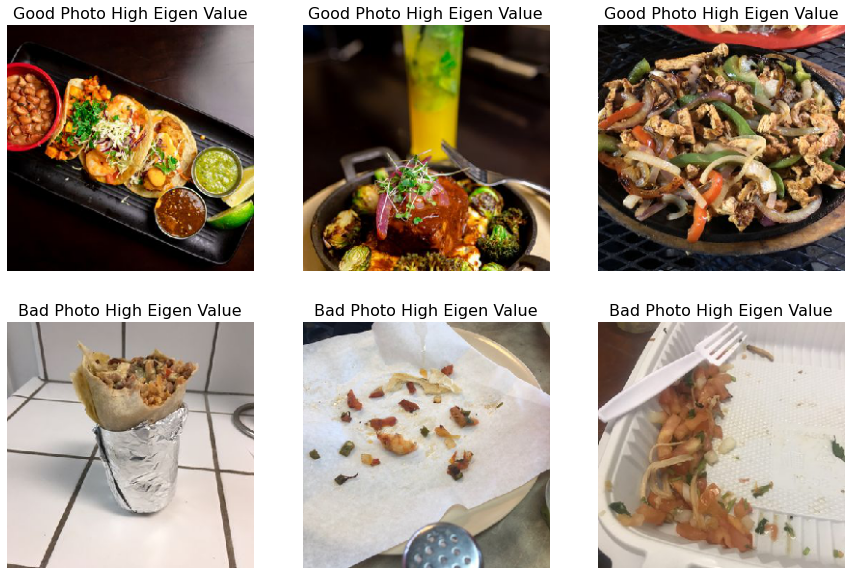

In [110]:
# Plotting a 2 x 3 image matrix; 
fig = plt.figure(figsize = (15,10))
for i in range(6):
    if i < 3:
        fp = f'{train_dir}/good/{select_good[i]}'
        label = 'Good Photo High Eigen Value'
    else:
        fp = f'{train_dir}/bad/{select_bad[i-3]}'
        label = 'Bad Photo High Eigen Value'
    ax = fig.add_subplot(2, 3, i+1, aspect='equal')
    
    # to plot without rescaling, remove target_size
    fn = image.load_img(fp, target_size = (256,256), 
                        color_mode='rgb')
    plt.imshow(fn, )
    plt.title(label,fontsize=16)
    plt.axis('off')
plt.savefig('classy-food/visuals/eigen_grid1',dpi=400,format='jpg')
plt.show()

### Conclusion
Classified or labeled sets of images can be visualized in different ways, especially if they have similar outlines.  In this example, outline variability within and between the sets makes things more difficult, but some conclusions can still be drawn about explains the most variability between the classes - probably evenness of the exposure, the food fineness of the food texture, and the presence/absence of a centered plate.  Also, food on the plate is better than an empty plate!